<h1 align="center"> Brain-Computer Interface Dataset </h1>
Acknoledgement:

This notebook was assembled by Suyee Lee, Kayvon Daie, Saskia de Vries .. with contribution from many others, slightly modified for this course.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h1>Overview:</h1>


In this tutorial, we'll use neural activity data collected from mouse primary motor cortex before, during, and after animals learn a brain-computer interface task to address the following question: How do neuron interactions change after learning?
    
The data we're working with is part of the ongoing [Credit Assignment During Learning project](https://www.allenneuraldynamics.org/projects/credit-assignment-during-learning) at the Allen Institute for Neural Dynamics. In this experiment, mice learn to control the activity of a specific neuron in order to receive rewards using a brain computer interface (BCI) paradigm. The activity of the conditioned neuron is read out in real time and is linked to the movement of a reward spout. Over a few trials, the activity of the conditioned neuron becomes coupled to the movement of the spout and the mouse learns to activate that neuron to move the spout towards its mouth to receive a reward. In contrast to other behavior tasks, this task enables us to study how learning of a single neuron can affect other cells in the network.

## **Background:**
    
This experiment was designed to test competing models of learning rules—such as Hebbian learning, long-range input modulation, and biologically plausible approximations of error backpropagation—by directly measuring changes in neural activity and inferred connectivity during learning. The core task involved a closed-loop BCI paradigm in which a single neuron’s activity controlled a reward mechanism. Because the mapping from activity to behavior was fully defined by the experimenter, this paradigm enables ground-truth labeling of neurons as behaviorally causal (e.g., the conditioned neuron) versus merely correlated.

To probe learning-related circuit changes, cellular-resolution two-photon photostimulation was used to perturb neurons before and after learning. By analyzing evoked responses, researchers could infer the presence and strength of functional connections. Learning-induced changes in connectivity were then compared to predictions from recurrent neural network models trained with different plasticity rules, enabling discrimination between competing learning algorithms.

## **Experiment:**
Neural activity was recorded from layer 2/3 excitatory neurons in the primary motor cortex of head-fixed mice using two-photon calcium imaging. Imaging was performed over multiple days as each animal learned and performed a BCI task. Each day, a new conditioned neuron (CN) was selected and the activity of this neuron was mapped in real-time to the position of a motorized reward port. To receive water rewards, mice had to learn to increase the activity of the conditioned neuron to move the port into reach.

In addition to the BCI task, the dataset includes blocks where spontaneous activity was recorded and photostimulation blocks in which individual or groups of neurons were optogenetically stimulated to assess their causal influence on the surrounding network. These connection mapping sessions were repeated daily to measure how connectivity changed as learning progressed. Imaging data were preprocessed using Suite2p or CellPose and include motion-corrected fluorescence traces, extracted ROIs, and stimulus-aligned behavioral data.

## **Approach:**  
What analysis method can we use to address this question?
    
One simple way to assess neuron interactions is by quantifying how correlated their activity patterns are. If neurons are consistently co-active, they are causally connected - likely connected directly, connected indirectly, or receive shared input as part of an interacting circuit.

## **Goals:**
This tutorial walks through how to:
* access the metadata and data
* plot neural activity aligned with experimental epochs and behavioral events
* use Pearson Correlation to assess changes in neural activity before and after learning

## **Resources:**

For further documentation on this dataset, refer to the [data book](https://allenswdb.github.io/physiology/ophys/BCI/BCI-overview.html)!
        
</div>

# Mount dataset, install dependencies:
s3fs  will allow us to access the data on the Amazon S3 server. This can be done from any PC.

hdmf_zarr will be used to open the data files that are optimized for cloud storage.

In [ ]:
!apt install s3fs
!mkdir -p ./aind-open-data/
!s3fs aind-open-data ./aind-open-data/ -o public_bucket=1
!pip install hdmf_zarr

# restart the session when you first run this block

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2>Import packages, mount google drive</h2>

In [ ]:
# General imports
import os
import numpy as np
import pandas as pd
from pathlib import Path
import scipy.stats as stats
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import urllib.request

# PyNWB imports
from hdmf_zarr import NWBZarrIO


In [ ]:
# mount S3 drive
s3_data_path = '/content/aind-open-data/'
Path(s3_data_path).mkdir(parents=True,exist_ok=True)# make the folder so it exists

!s3fs aind-open-data /content/aind-open-data/ -o public_bucket=1


In [ ]:
# If you want to save your data and figures on google drive, run this cell

# Setup and add files needed to access gdrive
from google.colab import drive                                   # these lines mount your gdrive to access the files we import below
drive.mount('/content/gdrive', force_remount=True)

import os
from pathlib import Path

save_path = '/content/gdrive/MyDrive/Analyzing-Open-Neuroscience-Data-Course-SZTE/BCI/'   # set this to wherever you want to save your data
# Delete /gdrive/MyDrive above to just save to colab

# check if folder already exists; if not, make it
# if it already exists, let us know
if os.path.isdir(save_path):
   print("Given directory exists")
else:
   print("Given directory doesn't exist, making it")
   Path(save_path).mkdir(parents=True,exist_ok=True)# make the folder so it exists


# change into the folder for the session and use it to save our figures

#print('data will be saved to {}'.format(save_path))

# check out your google drive!!

## Helper functions

In [ ]:
def filter_roi_table(nwbfile) -> pd.DataFrame:
    """
    Parameters:
    nwbfile: NWBFile
        NWBFile object containing roi table with image segmentation masks and soma classifications

    Outputs:
    filtered_roi_table: pd.DataFrame
        filtered ROI table with only ROIs that pass soma classifier and photostimulated and conditioned neurons
    """
    # Get photostim and cn indices from tables in NWB file
    photostim_ids = nwbfile.stimulus["PhotostimTrials"].to_dataframe().closest_roi.values
    cn_id = nwbfile.stimulus["Trials"].to_dataframe().closest_roi.values
    roi_table = nwbfile.processing["processed"].data_interfaces["image_segmentation"].plane_segmentations["roi_table"][:]

    missing_ids = np.unique(np.concatenate([photostim_ids, cn_id]))

    # Check which indices did not pass soma detection
    add_ids = []
    for idx in missing_ids:
        if roi_table.iloc[idx].is_soma == 0:
            add_ids.append(idx)
        else:
            continue

    # Filter roi table for those that pass is_soma and for indices of missing ids
    filtered_roi_table = roi_table[roi_table.is_soma==1]
    filtered_roi_table = pd.concat(
    [filtered_roi_table, roi_table.iloc[add_ids]],
    ignore_index=False  # reindex rows if you don’t care about preserving original indices
    )

    filtered_roi_table = filtered_roi_table[['image_mask']]

    return filtered_roi_table

def filter_dff(nwbfile, filtered_roi_table) -> pd.DataFrame:
    """
    Gets dff traces for ROIs that are likely somas and removes columns that are all NaNs.

    Parameters:
    nwbfile : NWBFile
        NWBFile object containing processed dff traces.
    filtered_roi_table : pd.DataFrame
        Filtered ROI table with only ROIs that pass soma classifier

    Outputs:
    cleaned_dff : np.ndarray
        Filtered array (n_frames x n_ROIs) with NaN-only columns removed.
    cleaned_roi_table : pd.DataFrame
        Filtered ROI table with corresponding ROIs removed.
    """

    # Load dff traces
    dff_traces = nwbfile.processing["processed"].data_interfaces["dff"].roi_response_series["dff"].data[:]

    # Select ROIs of interest
    filtered_dff_traces = dff_traces[:, filtered_roi_table.index]

    # Identify columns that are all NaN
    mask = ~np.all(np.isnan(filtered_dff_traces), axis=0)

    # Filter out NaN-only columns
    cleaned_dff = filtered_dff_traces[:, mask]
    cleaned_roi_table = filtered_roi_table[mask]

    return cleaned_dff, cleaned_roi_table



<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h1>Metadata: data about the data</h1>
    
For each experimental session, the scientists collect rich metadata that reports information about the equipment, materials, subject, and methods used. We can use the metadata to learn about the dataset and select interesting sessions to analyze.

First, we'll import the metadata stored in the `bci_metadata.csv` in the `/data/metadata/` folder as a Pandas DataFrame. (*If you don't see the `bci_metadata.csv` file, navigate to the `/code/metadata/` folder and run the python notebook called `bci_metadata.ipynb` which populates the metadata from the database and stores as a CSV.*)

    
**Metadata table:** each row represents a unique recording session and each column is a different metadata field. See the table below for the column descriptions.

| Column    | Description |
| -------- | ------- |
| project_name | project identifier|
| session_type   |  experiment identifier |
| id | data asset id |
| name | filename of data asset (raw) |
| subject_id| numerical id for animal subject  |
| genotype  | subject genotype   |
| virus   | injected virus type  |
| date_of_birth   | subject date of birth  |
| age   | subject age (days) |
| session_time |  experiment date (%Y-%m-%d %H:%M:%S)   |
| targeted_structure   | brain area recorded from |
| ophys_fov   | field of view identifier  |
| session_number    | behavior training session number   |

In [ ]:
# The metadata can be found on the github page  as a csv file: https://raw.githubusercontent.com/rozmar/Analyzing-Open-Neuroscience-Data-Course-SZTE/refs/heads/main/Module_2/bci_metadata.csv
# use the urllib.request library to open the csv file as a pandas dataframe
url = 'https://raw.githubusercontent.com/rozmar/Analyzing-Open-Neuroscience-Data-Course-SZTE/refs/heads/main/Module_2/bci_metadata.csv'
metadata = pd.read_csv(urllib.request.urlopen(url))
metadata.head()

<div style="background: #F0FAFF; border-radius: 3px; padding: 10px;">

Querying the length of the metadata table tells us how many recording sessions are in this dataset.

In [ ]:
print(f"Number of sessions: {len(metadata)}")

<div style="background: #F0FAFF; border-radius: 3px; padding: 10px;">

<h1>Neural Recordings Across Behavior Sessions</h1>
    
Neural activity was recorded from each subject over multiple days as the animal performs the BCI task, enabling analysis of activity dynamics throughout the learning process.
    
We can count the number of rows associated with each `subject_id` to quantify the number of sessions per subject we have access to.
    
</div>

In [ ]:
metadata.value_counts(['subject_id'])

<div style="background: #F0FAFF; border-radius: 3px; padding: 10px;">

## **Session Number and Ophys FOV**
    
A few things metadata columns to note when looking at the sessions:
    
`session_number` indicates the number of days the animal has performed the task. You can use this to compare how neural activity changes as the subject becomes more experienced with the task.
    
`ophys_fov` is an identifier for the field of view (FOV). Recordings were typically made from the same FOV across several days, then sometimes changed. Note that while the same neurons are present across several recording sessions, these neurons were not explicitly tracked in the dataset.
    
</div>

In [ ]:
metadata[['name', 'subject_id', 'ophys_fov', 'session_number']]

<div style="background: #F0FAFF; border-radius: 3px; padding: 10px;">
    
## **Cell Targeting Strategies**
    
Each session includes neural activity recordings from excitatory neurons in the mouse primary motor cortex. A few different genetic labelling strategies were used to enable targeting and recording from select cell types.
We can see the unique combinations by applying the `value_counts` function to the `genotype`, `virus` and `targeted_structure` columns.
    
Importantly, note the presence of **GCaMP** in either the genotype or virus information. GCaMP is a genetically encoded calcium indicator, a protein that fluoresces when it binds to calcium. When genetically inserted into a neuron it can be used to read out changes in intracellular calcium levels as a marker of neural activity.
    
For more information on transgenic tools and the genotypes/viruses used in these experiments, see the [transgenic tools](https://allenswdb.github.io/background/transgenic-tools.html) page in the data book.

</div>

![GCaMP image](https://physoc.onlinelibrary.wiley.com/cms/asset/0a5b1e68-22f9-43ee-b655-9f8ad71931e7/tjp15473-gra-0001-m.jpg)
    
[Zhang and Looger, 2023](https://physoc.onlinelibrary.wiley.com/doi/full/10.1113/JP283832)

In [ ]:
metadata[['genotype', 'virus', 'targeted_structure']].value_counts()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h1> Loading session data</h1>
    
All the available data is attached to this capsule and can be found in the `/data/brain-computer-interface` folder. The data is organized by session.
    
## **Select a session**
    
Using the metadata dataframe, let's select a session and load the data. We'll grab the `name` value for the selected session.

In [ ]:
# Select a mouse
subject_id = 754303

# Look at its metadata, sorted by 'session_number'
this_mouse_metadata = metadata[metadata['subject_id']==subject_id].sort_values(by='session_number')
this_mouse_metadata

In [ ]:
# Select a session for this mouse
session_name = this_mouse_metadata.name.values[2]
print('Selected session is', session_name)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

There should be a folder for each session in the `/data/brain-computer-interface` folder. Within each session folder is an NWB directory. Get the file path to the NWB directory for the selected session.  

In [ ]:
# Get the directory for this dataset
import shutil

session_dir = os.path.join('/content/aind-open-data/', session_name)
save_path = '/content/'
# Now find the NWB file and set the path to load it
nwb_file = [file for file in os.listdir(session_dir) if 'nwb' in file][0]
nwb_path = os.path.join(session_dir, nwb_file)
# local_nwb_path = os.path.join(save_path,nwb_file)
# if nwb_file not in os.listdir(save_path):
#   print('downloading nwb file.. stand by')
#   shutil.copytree(nwb_path, local_nwb_path)
# else:
#   print('nwb file already copied')

print(nwb_path)


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h1>Neurodata Without Borders (NWB) files</h1>
    
The session data is stored in NWB format. NWB files are hierarchical containerized systems that are capable of storing many data types, like tables, timeseries arrays, and strings.
    
The NWB files that we're working with contain a lot of data - up to an hour of recorded neural activity collected at 58 Hz and other derived data products. The NWB files we'll be working with are in a Zarray (Zarr) backend, which compresses our data for efficient storage and loading. To load the NWB files, we'll pass the path to the NWB directory through the `NWBZarrIO` function from `hdmf-zarr` like so.

In [ ]:
with NWBZarrIO(str(nwb_path), 'r') as io:
    nwbfile = io.read()
    print('Loaded NWB file from:', nwb_path)

#nwbfile

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h1>Plot Neural Activity Trace</h1>
    
Now that we've loaded the NWB object, let's load the neural activity traces and plot the activity of a single neuron.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## **dF/F: Change in Fluorescence Over Fluorescence**

For each ROI, the change in fluorescence (df) over a baseline (F) is calculated, resulting in the dff traces.

First, the change in fluorescence within each ROI is calculated. Then, the signal is corrected for noise by subtracting the local neuropil signal. The corrected signal is then demixed from potentially overlapping ROIs. Finally, the corrected change in fluorescence signal is normalized over baseline fluorescence (median fluorescence over a 60s time window centered around each time point).

The final "dff" data is stored in the **processing** container of the NWB file. We've written 2 utility functions `filter_roi_table` and `filter_dff` that will extract the dff array and the corresponding ROI image masks and filter for only good ROIs (ROIs that are likely cell bodies and removes bad traces).

Let's load 'dff', nframes x nrois array.

In [ ]:
filtered_roi_table = filter_roi_table(nwbfile) # Gets ROI table for good ROIs only
cleaned_dff, cleaned_roi_table = filter_dff(nwbfile, filtered_roi_table) # Gets dff for good ROIs, removes rows in dff and ROI table for bad traces

Important notes about dff and the ROI table: The outputs of `filter_roi_table` and `filter_dff` contain only the good ROIs with valid signals. The `id` column of the ROI table is used for indexing into dff of the original dff array. This will be important later when trying to pull experimentally relevant neurons in dff.

In [ ]:
print('dff shape(nframes, nrois):', np.shape(cleaned_dff))

cleaned_roi_table

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## **Plot the activity of a single neuron**
    
Now that we've unpacked the data pieces a bit, let's select a neuron and plot its activity over the entire session.
    
`dff_traces` is organized by frames. For visualization, let's convert this to timestamps using the `imaging_rate` - the rate at which the 2P frames were acquired.

In [ ]:
#get imaging frame rate from the NWB file in Hz
frame_rate = nwbfile.imaging_planes["processed"].imaging_rate

#convert to seconds
time_step = 1/frame_rate

#create equally spaced timestamps array
n_frames = cleaned_dff.shape[0]
timestamps = np.linspace(0, (time_step*n_frames), num=n_frames)

In [ ]:
# Pick an ROI
ROI = 15

# Plot dff trace for selected ROI
plt.figure(figsize=(10,4))
plt.plot(timestamps, cleaned_dff[:, ROI], color='black')

plt.ylabel('dF/F')
plt.xlabel('Time (s)')
plt.title('dF/F for ROI '+str(ROI))
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h1> Epochs Table </h1>

What do you notice about the dynamics of the activity trace? There are periods where the neuron is more active than others. Remember that during the experiment, there was a photostimulation epoch and a BCI behavior task epoch, which could explain some of the changes in activity.

The epoch table in the NWB file contains the start and stop times/frames for each experimental epoch. We can use the start/stop frames to index into the dff array.
The epochs table is contained in the **intervals** container of the NWB file. The table is stored as a DynamicTable, which we convert to a Pandas DataFrame using `to_dataframe`, for better accessibility.

In [ ]:
# Load the epochs table from the NWB file
epoch_table = nwbfile.intervals["epochs"].to_dataframe()
epoch_table

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## **Plot neuron activity trace with epochs overlaid**
    
Let's add some experimental context to the plot above. We'll plot the dF/F trace for the ROI we selected above with the stimulus epochs overlaid in color.


In [ ]:
# Set up figure
plt.figure(figsize=(10, 4))

# Plot dff trace
plt.plot(timestamps, cleaned_dff[:, ROI], color="black")

# Get epoch info
epoch_table = nwbfile.intervals["epochs"].to_dataframe()
stimulus_names = epoch_table.stimulus_name.unique()

# Define fixed colors
color_map = {
    "spont": "orange",
    "photostim": "purple",
    "other": "green"
}

# Plot shaded blocks for each stimulus epoch
for stimulus_name in stimulus_names:
    stim_epoch = epoch_table[epoch_table.stimulus_name == stimulus_name]

    # Assign color based on name
    lname = stimulus_name.lower()
    if "spont" in lname:
        color = color_map["spont"] # All spontaneous epochs == orange
    elif "photostim" in lname:
        color = color_map["photostim"] # All photostim epochs == purple
    else:
        color = color_map["other"] # Other (BCI) == green

    plt.axvspan(stim_epoch.start_time.values[0], stim_epoch.stop_time.values[0], color=color, alpha=0.3, label=stimulus_name)

# Labels and title
plt.ylabel("dF/F")
plt.xlabel("Time (s)")
plt.title(f"Stimulus epochs and dF/F for ROI {ROI}")
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #DFF0D8; ">

## **Exercise:**
    
Try selecting a different neuron and plotting its neural activity with epochs overlaid. How does the activity of the two neurons compare?

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h1> Brain-Computer Interface (BCI) Paradigm </h1>
    
During the BCI epoch, the animal is learning to control the movement of a lickspout with its own neural activity! One of the advantages of using 2p calcium imaging during this task is that the experimenters can record at single neuron resolution and thus condition the activity of a single neuron to perform the task.
        
Let's take a look at the activity of the conditioned neuron during the BCI epoch.
    
We already showed how to plot the neural activity trace for a single neuron. Let's walk through a few other data pieces relevant to the BCI behavior to plot the activity of the conditioned neuron aligned with different behavior events.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## **Stimulus Tables**

Within the `stimulus` container of the NWB file, you'll find two tables: `PhotostimTrials` and `Trials`.
    
**Photostim Trials**

We won't go into the photostimulation trials table in this tutorial, but see the [BCI Data Book page](https://allenswdb.github.io/physiology/ophys/BCI/BCI-dataset.html) for a full description.

In [ ]:
# These are the available stimulus tables
nwbfile.stimulus.keys()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## **Trials table: BCI behavior trials**
        
The trials table contains information about the behavior events, such as when the mouse licked or received a reward, on a trial-by-trial basis. Here is a full description of the columns of this table:

| Column    | Description |
| -------- | ------- |
| start_time  | trial start (s)  |
| stop_time | trial end (s)   |
| go_cue |  time of go cue relative to start time (s)   |
| hit   |  boolean of whether trial was hit   |
| lick_l  | lick times (s)   |
| reward_time   | reward delivery time (s)   |
| threshold_crossing_times    | time when reward port crossed position threshold (s)   |
| zaber_steps_times   | position of reward port  |
| tiff_file    | data source file  |
| start_frame    | trial start (frame)  |
| stop_frame    | trial end (frame)  |
| conditioned_neuron_x    | coordinate for conditioned neuron (pixels)  |
| conditioned_neuron_y    | coordinate for conditioned neuron (pixels)  |
| closest_roi    | index in dff that corresponds to the photostimulated neuron  |


In [ ]:
# Load the BCI trials table
trials = nwbfile.stimulus["Trials"].to_dataframe()
trials.head()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
## **Plot Conditioned Neuron activity aligned with behavior events**

To plot the neural activity of the conditioned neuron, we need the value of the `closest_roi` column, which contains the column index into the dF/F array for the conditioned neuron selected in this session.
    
**Important Note:** Since we filtered the original dff array for good ROIs, we changed the shape of the array. To get the conditioned neuron index, we need to find which row in the `cleaned_roi_table` has id == 33.

In [ ]:
print(f"Conditioned Neuron Index (in original unfiltered dff array): {trials.closest_roi.unique()[0]}")

In [ ]:
# to get the index into the filtered_dff_traces, we need to find the correct index in the cleaned_roi_table
cn_index = np.where(cleaned_roi_table.index == trials.closest_roi.unique()[0])[0][0]
print(f"Conditioned Neuron Index in cleaned dff array: {cn_index}")

In [ ]:
# Plot the activity of the conditioned neuron over a narrow time window

# Set up figure
plt.figure(figsize=(12, 8))

# Plot dF/F of conditioned neuron
plt.subplot(2, 1, 1) # Set up subplots - we'll add the behavior events later on
plt.plot(timestamps, cleaned_dff[:, cn_index], color='black', label="dF/F")
plt.ylabel("dF/F")
plt.title("Conditioned Neuron Activity")
plt.ylim(-2, 8)
plt.xlim(1505, 1530) # Plot a select sample of trials

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Add Behavior Events
    
We'll add the trial start (start_time), when the lickport moved (zaber_step_times), the reward times (reward_time), and the lick times (lick_times). Note that units for the zaber_step_times and reward_time is in seconds and is reported relative to the start of the trial.
    
Let's build a list of all the times for each behavioral event. For each trial, we need to get the event times for a given behavioral event and add the start_time of that trial to it.

In [ ]:
# Convert behavior events reported relative to trial start to absolute time

#create empty lists for the behavior events
lick_times = []
go_cues = []
rewards = []
threshold_crossing_times = []
zaber_step_times = []

#for each trial, add the event times to trial start and append to appropriate list
for index, row in trials.iterrows():
    lick_times.append(row.lick_L[np.isfinite(row.lick_L)] + row.start_time) # use isfinite to filter out nans
    zaber_step_times.append(row.zaber_step_times[np.isfinite(row.zaber_step_times)] + row.start_time)
    rewards.append(row.reward_time + row.start_time)

#reshape lick_times and zaber_step_times (this is needed because there is a list of times for each trial)
lick_times = np.hstack(lick_times)
zaber_step_times = np.hstack(zaber_step_times)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Let's plot all of the lick times. We can use `np.ones_like` to make an array of 1s the length of the number of values in the rewards list.
    
So, at every time point indicated in lick_times, we have a corresponding 1 value to plot.

In [ ]:
plt.stem(lick_times, np.ones_like(lick_times),
         linefmt='b-', markerfmt=' ', basefmt=" ", label="Licks")
plt.xlabel("Time (s)")
plt.xlim(1505, 1530)
plt.ylim(-1, 1.5)
plt.title("Lick times")

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Now that we have the behavior events in absolute time, let's plot both the dff trace of the conditioned neuron and the behavior events.

In [ ]:
# Set up figure
plt.figure(figsize=(12, 8))

# Plot dF/F of conditioned neuron
plt.subplot(2, 1, 1) # Set up subplots - we'll add the behavior events later on
plt.plot(timestamps, cleaned_dff[:, cn_index], color='black', label="dF/F")
plt.ylabel("dF/F")
plt.title("Conditioned Neuron Activity")
plt.ylim(-2, 8)
plt.xlim(1505, 1530) # Plot a select sample of trials

# Plot behavior events using plt.stem
plt.subplot(2, 1, 2)
plt.stem(trials.start_time.values, -np.ones_like(trials.start_time.values),
         linefmt='g-', markerfmt=' ', basefmt=" ", label="Trial start")
plt.stem(zaber_step_times, np.ones_like(zaber_step_times),
         linefmt='k-', markerfmt=' ', basefmt=" ", label="Zaber steps")
plt.stem(lick_times, -np.ones_like(lick_times),
         linefmt='b-', markerfmt=' ', basefmt=" ", label="Licks")
plt.stem(rewards, -np.ones_like(rewards),
         linefmt='r-', markerfmt=' ', basefmt=" ", label="Rewards")
plt.axhline(0, color = 'black', linestyle = '-', linewidth = 1)

plt.xlabel("Time (s)")
plt.ylabel("Events")
plt.ylim(-1.5, 1.5)
plt.xlim(1505, 1530)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
## **Comparing Conditioned Neuron Activity to Other Neurons**

What does the conditioned neuron activity look like in relation to other neurons in the FOV? How sparse is the neural activity during the BCI task?
    
Let's plot the activity of other neurons and compare their activity to the conditioned neuron.  

In [ ]:
# Initialize Variables
start_time = 1505 # using the same time window bins from above
stop_time = 1530
nrois_to_plot = 10 # Select number of neurons to plot
offset = 10 # Offset each neuron for plotting

# Convert time window to frames
start_frame = int(start_time * frame_rate)
stop_frame  = int(stop_time * frame_rate)

# Slice the frame window out of the filtered_dff_traces array
subsample_dff = cleaned_dff[start_frame:stop_frame, :]

# Set up figure
plt.figure(figsize=(12, 8))

# Plot other neurons in dff_trace during this time window with an offset
plt.subplot(2,1,1)
for roi in range(0, nrois_to_plot):
    plt.plot(timestamps[start_frame:stop_frame], subsample_dff[:, roi]+roi*offset, color = 'black')

# Plot conditioned neuron
plt.plot(timestamps[start_frame:stop_frame], subsample_dff[:, cn_index]-offset, color = 'red', label = 'CN')
plt.legend(loc="upper right")


# Plot behavior events
plt.subplot(2,1,2)
plt.stem(zaber_step_times, np.ones_like(zaber_step_times),
         linefmt='k-', markerfmt=' ', basefmt=" ", label="Zaber steps")
plt.stem(lick_times, -np.ones_like(lick_times),
         linefmt='b-', markerfmt=' ', basefmt=" ", label="Licks")
plt.stem(rewards, -np.ones_like(rewards),
         linefmt='r-', markerfmt=' ', basefmt=" ", label="Rewards")
plt.stem(trials.start_time.values, -np.ones_like(trials.start_time.values),
         linefmt='g-', markerfmt=' ', basefmt=" ", label="Trial start")
plt.axhline(0, color = 'black', linestyle = '-', linewidth = 1)

plt.legend(loc="upper right")
plt.xlim(1505, 1530)
plt.ylim(-1.5, 1.5)
plt.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h1> Quantifying pairwise neural activity correlations with the conditioned neuron </h1>

Some neurons seem to act independently, while others fire in sync with the conditioned neuron — a hint that they might be functionally connected.
We can quantify this co-activity by calculating the Pearson correlation, which tests whether the activity of two neurons changes together in a linear fashion.
        
## **Correlations**

Pearson Correlation is computed using the formula:


correlation_coefficient_formula.svg


If the two variables are positively correlated, a large response from cell A will be matched with a large response in cell B. If they are weakly correlated, the response size of cell A will have no relationship with the response size of cell B. And if they are negatively correlated, cell B will have small responses when cell A has large responses.

If two neurons are highly correlated, this could be due to a direct connection between the neurons or a shared input.



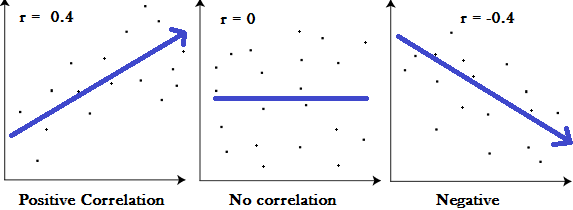




<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Let's select the same 10 neurons from the plot above and apply Pearson Correlation to quantify how correlated these other neurons are with the conditioned neuron. We'll use `pearsonr` from `scipy.stats` to compute correlations.

In [ ]:
target = subsample_dff[:, cn_index] # Get dff for CN only
others = subsample_dff[:, 0:nrois_to_plot] # Get dff for other neurons

# Iteratively compute pairwise correlations between just cn and other select neurons, store each value in an array
correlations = np.array([pearsonr(target, others[:, i])[0] for i in range(others.shape[1])])

# Plot Correlations
plt.plot(correlations, 'o')
plt.ylim(-1, 1)
plt.xlabel('ROI #')
plt.ylabel('Correlation Coefficient')
plt.title(f"Pairwise Correlations Between CN and ROI # 0-{nrois_to_plot}")

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h1> Quantifying activity correlations before and after BCI learning </h1>

Now, we have a way to quantify how correlated the conditioned neuron activity is to other neurons in the field of view. We see that looking over this narrow time window and across some neurons, the conditioned neuron is correlated with a few neurons. Let's expand on this analysis. **How do you think the correlations between the conditioned neuron and the rest of the neurons in the network changes as the animal learns the task?** (Remember that we use the pairwise correlations to infer causal connectivity).
    

To answer this question, let's quantify correlations between the conditioned neuron and all good ROIs during a time period before and after the BCI task.
We can use the spontaneous activity epoch here as it provides a long period of neural activity without any stimulus or manipulation, which is useful for quantifying connectivity.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Get df/F for Spontaneous Epoch
    
First, we need to subsample the dff array for just the spontaneous epochs before and after the BCI task. Same as before, we'll take a frame window slice out `filtered_dff_traces` that span the spontaneous epochs, which we can pull from the epoch table. We'll create 2 new arrays - one for the spontaneous period before BCI and oen for the spontaneous period after.

In [ ]:
# Get the start and stop frames for the spontaneous epochs from the epoch table

# The spontaneous period before the task consists of the first two spontaneous blocks
spontaneous_pre_start = epoch_table[epoch_table.stimulus_name == 'spont'].start_frame.item()
spontaneous_pre_stop = epoch_table[epoch_table.stimulus_name == 'spont'].stop_frame.item()

# The last spontaneous period is the last spontaneous epoch
spontaneous_post_start = epoch_table[epoch_table.stimulus_name == 'spont_post'].start_frame.item()
spontaneous_post_stop = epoch_table[epoch_table.stimulus_name == 'spont_post'].stop_frame.item()

# Index into the dff traces array for spontaneous epochs
dff_pre = cleaned_dff[spontaneous_pre_start:spontaneous_pre_stop, :]
print(dff_pre.shape)

dff_post = cleaned_dff[spontaneous_post_start:spontaneous_post_stop, :]
print(dff_post.shape)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Compute Correlations Between CN and Other Neurons
    
Now that we've sub-sampled our dff array for only the spontaneous epochs pre- and post-BCI, compute the pairwise correlations between the conditioned neuron and all other good ROIs in dff.

In [ ]:
# Compute correlations for spontaneous pre-BCI epoch
target_pre = dff_pre[:, cn_index]
others_pre = dff_pre[:]
correlations_pre = np.array([pearsonr(target_pre, others_pre[:, i])[0] for i in range(others_pre.shape[1])])

# Compute correlations for spontaneous post-BCI epoch
target_post = dff_post[:, cn_index]
others_post = dff_post[:]

correlations_post = np.array([pearsonr(target_post, others_post[:, i])[0] for i in range(others_post.shape[1])])

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Compare Changes in Correlations
    
We'll visualize the distribution of the correlations as a histograme. Note that we need to remove the self-correlation, the comparison of the conditioned neuron with itself.

In [ ]:
# Plot correlations as a histogram

# Get conditioned neuron index
cn_index = np.where(cleaned_roi_table.index == trials.closest_roi.unique()[0])[0][0]

# Remove the self-correlation (comparing cn with cn)
mask = np.arange(len(correlations_pre)) != cn_index
cn_correlations_pre = correlations_pre[mask]
cn_correlations_post = correlations_post[mask]

# Define shared bin edges
bins = np.linspace(-0.1, 0.1, 100)

# Plot histograms
plt.hist(cn_correlations_pre, bins=bins, color='green', label='pre', histtype='step')
plt.hist(cn_correlations_post, bins=bins, color='purple', label='post', histtype='step')

plt.title('Correlations with Conditioned Neuron Before and After BCI Learning')
plt.xlabel('r value')
plt.ylabel('# cell pairs')
plt.xlim(-0.1, 0.2)
plt.legend()

In [ ]:
# Calculate the mean of the pre and post distributions

print('mean pre:', cn_correlations_pre.mean())
print('mean post:', cn_correlations_post.mean())

# Run the stats!
t, p_val = stats.ttest_ind(cn_correlations_pre, cn_correlations_post)
print('p_val:', p_val)

# Is this statistically significant? If p-value <0.05, then yes.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; ">
<h1> Questions and analyses to explore further: </h1>

* Do non-conditioned neurons change their activity during the BCI task? Were these cells more highly connected to the conditioned neuron prior to BCI learning?

* How does the activity of the conditioned neuron change throughout the BCI task? Quantify it's mean activity across trials in the behavior block. How does the activity relate to the animal's behavior?
    
* Which neuron pairs have the largest changes in correlations after BCI learning? Do they increase or decrease? Are they also correlated to the conditioned neuron?
   
* Do correlated neurons tend to have stronger connections? Use the photostimulation periods to measure connection strength across neurons based on their response latency and relate to spontaneous activity correlations.
    